# Exploratory Data Analysis (EDA)

This notebook is designed to perform exploratory data analysis on the mental health text classification dataset. It includes loading the dataset, visualizing class distributions, and analyzing text features.

## Loading the Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../Data/Suicide_Detection.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


In [4]:
df = df.drop(columns='Unnamed: 0', axis=0)
df.describe(include='all')

,text,class
count,232074,232074
unique,232074,2
top,I still haven't beaten the first boss in Hollo...,suicide
freq,1,116037


In [5]:
df.sample(6)

,text,class
187881,"I love you all Ok, so I’ll be honest, I have b...",non-suicide
124270,Anyone think nothingness would be easier?The m...,suicide
12204,Any chill community? Chill community for lgbt ...,non-suicide
124429,I'm scaredI think I may be depressed. I've bot...,suicide
75679,I don't know anymore Life has been a shit hole...,non-suicide
62496,Absolute failureI flunked out of college 3 yea...,suicide


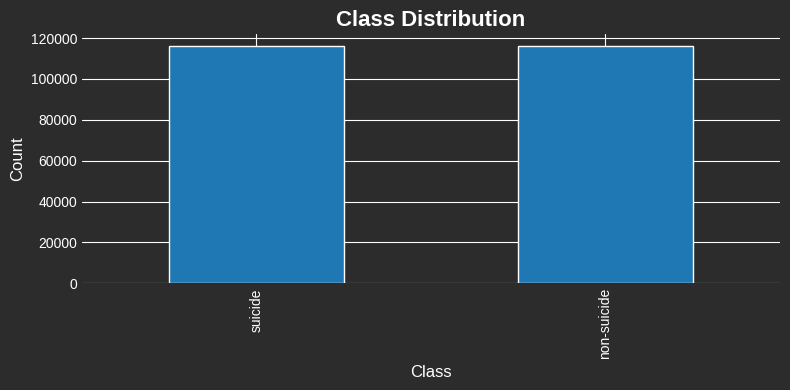

In [6]:
with plt.style.context('seaborn-v0_8-darkgrid'):
    fig, ax = plt.subplots(figsize=(8, 4), facecolor='#444444')
    bars = df['class'].value_counts().plot(kind='bar', ax=ax, color='#1f77b4', edgecolor='white')

    ax.set_title('Class Distribution', fontsize=16, color='white', weight='bold')
    ax.set_xlabel('Class', fontsize=12, color='white')
    ax.set_ylabel('Count', fontsize=12, color='white')

    ax.tick_params(colors='white')
    ax.set_facecolor('#2c2c2c')
    fig.patch.set_facecolor('#2c2c2c')

    plt.tight_layout()
    plt.savefig('../Outputs/Images/class_distribution')
    plt.show()

## Text Cleaning & Quality Inspection

In [7]:
import re
import emoji

emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags
         "]+", flags=re.UNICODE)

In [8]:
def summary_text(df, save = False):
    """Generate a summary of the text column in the DataFrame."""
    total_texts = df['text'].count()

    nulls = df['text'].isnull().sum()

    empty_texts = (df['text'].str.strip() == '').sum()

    duplicates = df.duplicated(subset='text').sum()

    newline_counts =(df['text'].str.contains('\n')).sum()

    tabular_counts = (df['text'].str.contains('\t')).sum()

    double_spaces = (df['text'].str.contains('  ')).sum()

    emojis_counts = df['text'].str.contains(emoji_pattern).sum()

    html_counts = df['text'].str.contains('<.*?>').sum()

    df_quality = pd.DataFrame({
        'Total Texts': [total_texts],
        'Nulls': [nulls],
        'Empty Texts': [empty_texts],
        'Duplicates': [duplicates],
        'Newlines': [newline_counts],
        'Tabs': [tabular_counts],
        'Double Spaces': [double_spaces],
        'Emojis': [emojis_counts],
        'HTML Tags': [html_counts]
    })
    df_quality.index = ['Quality Issues']
    df_quality = df_quality.T

    if save:
        df_quality.to_csv('../Outputs/Tables/quality_inspection.csv')

    print(df_quality)


In [9]:
summary_text(df, save=True)

               Quality Issues
Total Texts            232074
Nulls                       0
Empty Texts                 0
Duplicates                  0
Newlines                97638
Tabs                       88
Double Spaces           26871
Emojis                   8254
HTML Tags                   0


In [10]:
def text_cleaning(text):
    """Clean the input text by removing newlines and tabs, and replace emojis with text placeholders."""
    text = text.replace('\n', ' ').replace('\t', ' ')
    text = emoji.demojize(text)
    text = text.strip()
    text = text.lower()
    text = re.sub(emoji_pattern, '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [11]:
df['text'] = (df['text'].apply(text_cleaning))
df = df[df['text'].str.strip() != '']
df = df.drop_duplicates(subset='text')

In [12]:
summary_text(df)

               Quality Issues
Total Texts            231979
Nulls                       0
Empty Texts                 0
Duplicates                  0
Newlines                    0
Tabs                        0
Double Spaces               0
Emojis                      0
HTML Tags                   0


In [13]:
df.to_parquet('../Data/cleaned_suicide_detection.parquet', index=False)

## Textual Structure Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [2]:
df = pd.read_parquet('../Data/cleaned_suicide_detection.parquet')

In [3]:
df['char_len'] = df['text'].str.len()
df['token_count'] = df['text'].str.split().apply(len)
df['unique_token'] = df['text'].str.split().apply(lambda x : len(x))

df.describe()

,char_len,token_count,unique_token
count,231979.000000,231979.000000,231979.000000
mean,693.693843,131.920838,131.920838
std,1350.145371,217.480585,217.480585
min,3.000000,1.000000,1.000000
25%,140.000000,26.000000,26.000000
50%,316.000000,60.000000,60.000000
75%,800.000000,155.000000,155.000000
max,211626.000000,9684.000000,9684.000000


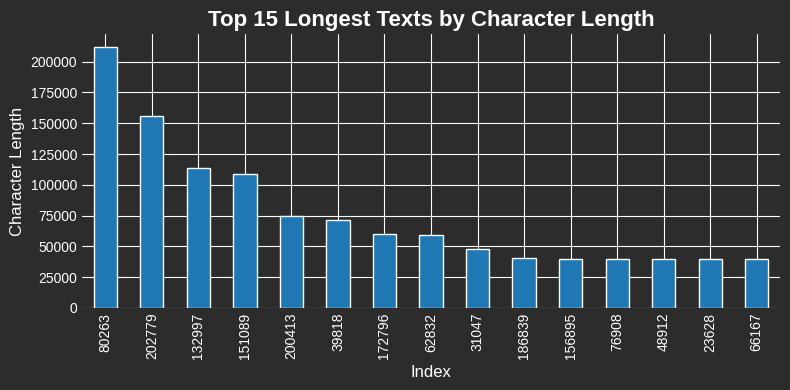

In [22]:
with plt.style.context('seaborn-v0_8-darkgrid'):
    fig, ax = plt.subplots(figsize=(8, 4), facecolor='#444444')
    bars = df['char_len'].sort_values(ascending=False).head(15).plot(kind='bar', ax=ax, color='#1f77b4', edgecolor='white')

    ax.set_title('Top 15 Longest Texts by Character Length', fontsize=16, color='white', weight='bold')
    ax.set_xlabel('Index', fontsize=12, color='white')
    ax.set_ylabel('Character Length', fontsize=12, color='white')

    ax.tick_params(colors='white')
    ax.set_facecolor('#2c2c2c')
    fig.patch.set_facecolor('#2c2c2c')

    plt.tight_layout()
    plt.savefig('../Outputs/Images/top15_char_len')
    plt.show()

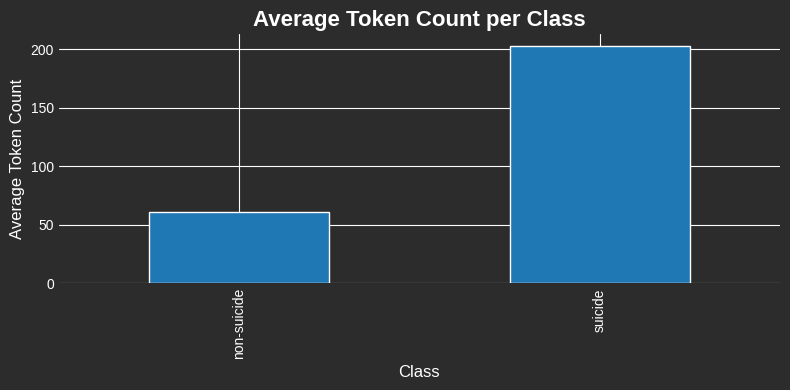

In [23]:
with plt.style.context('seaborn-v0_8-darkgrid'):
    fig, ax = plt.subplots(figsize=(8, 4), facecolor='#444444')
    avg_token_count = df.groupby('class')['token_count'].mean()
    bars = avg_token_count.plot(kind='bar', ax=ax, color='#1f77b4', edgecolor='white')

    ax.set_title('Average Token Count per Class', fontsize=16, color='white', weight='bold')
    ax.set_xlabel('Class', fontsize=12, color='white')
    ax.set_ylabel('Average Token Count', fontsize=12, color='white')

    ax.tick_params(colors='white')
    ax.set_facecolor('#2c2c2c')
    fig.patch.set_facecolor('#2c2c2c')

    plt.tight_layout()
    plt.savefig('../Outputs/Images/avg_token_count_per_class')
    plt.show()

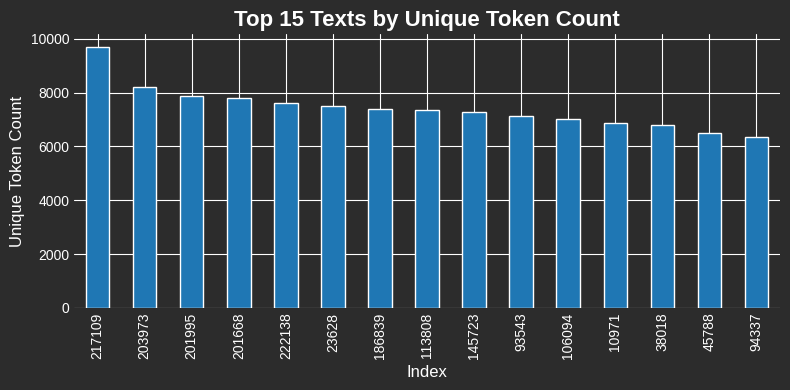

In [24]:
with plt.style.context('seaborn-v0_8-darkgrid'):
    fig, ax = plt.subplots(figsize=(8, 4), facecolor='#444444')
    bars = df['unique_token'].sort_values(ascending=False).head(15).plot(kind='bar', ax=ax, color='#1f77b4', edgecolor='white')
    ax.set_title('Top 15 Texts by Unique Token Count', fontsize=16, color='white', weight='bold')
    ax.set_xlabel('Index', fontsize=12, color='white')
    ax.set_ylabel('Unique Token Count', fontsize=12, color='white')

    ax.tick_params(colors='white')
    ax.set_facecolor('#2c2c2c')
    fig.patch.set_facecolor('#2c2c2c')

    plt.tight_layout()
    plt.savefig('../Outputs/Images/top15_unique_token_count')
    plt.show()

In [5]:
text = ' '.join(df['text'])
text_class = df.groupby('class')['text'].apply(lambda x: ' '.join(x))

brain_mask = np.array(Image.open('../src/Images/brain.png'))
brain_mask = 255 - brain_mask

mental_health = np.array(Image.open('../src/Images/mental-health.png'))
mental_health = 255 - mental_health

broken_heart = np.array(Image.open('../src/Images/broken-heart.png'))
broken_heart = 255 - broken_heart

In [6]:
def wordcloud_generater(text, title, path, mask=None):
    """Generate a word cloud from the given text."""
    cloud = WordCloud(
        scale=3,
        max_words=150,
        colormap='RdYlGn',
        background_color='#444444',
        mask=mask,
        collocations=True
    ).generate(text)

    with plt.style.context('seaborn-v0_8-darkgrid'):
        plt.figure(figsize=(10, 8), facecolor='#444444')
        plt.imshow(cloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=16, color='white', weight='bold')
        plt.savefig(path, bbox_inches='tight', dpi=300)
        plt.show()

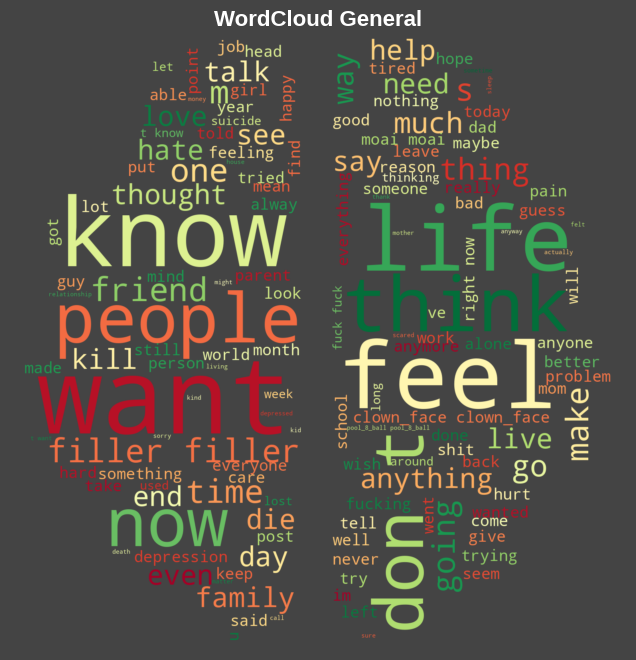

In [7]:
wordcloud_generater(text, 'WordCloud General', '../Outputs/Images/general_wordcloud', brain_mask)

In [9]:
wordcloud_generater(text_class['non-suicide'], 'WordCloud Non Suicide', '../Outputs/Images/non_suicide_wordcloud', mental_health)

ValueError: Couldn't find space to draw. Either the Canvas size is too small or too much of the image is masked out.

In [10]:
wordcloud_generater(text_class['suicide'], 'WordCloud Suicide', '../Outputs/Images/suicide_wordcloud', broken_heart)

ValueError: Couldn't find space to draw. Either the Canvas size is too small or too much of the image is masked out.